## MCX simulation based on package

In [1]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib
#! git clone --recursive https://github.com/fangq/mcx.git

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pmcx

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder_path = '/content/drive/MyDrive/MCX_data'
if folder_path not in sys.path:
    sys.path.append(folder_path)
from FD_msNIRS import mcx_simulation as ms

In [4]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### MCX Simulation using packgae

In [5]:
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [6]:
n = 1.370
c = 2.998e+10
c = (c / n) # cm/s
ua = 0.01 # mm-1
us = 15 # mm-1
ua_cm = ua*10
us_cm = us*10

In [7]:
data, time_unit = ms(ua, us, g=0.85, n=1.370, distance = 15, tend =1e-08, devf = 1000, nphoton = 1e8)

nphoton: 1e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1


In [8]:
print(len(data))

1000


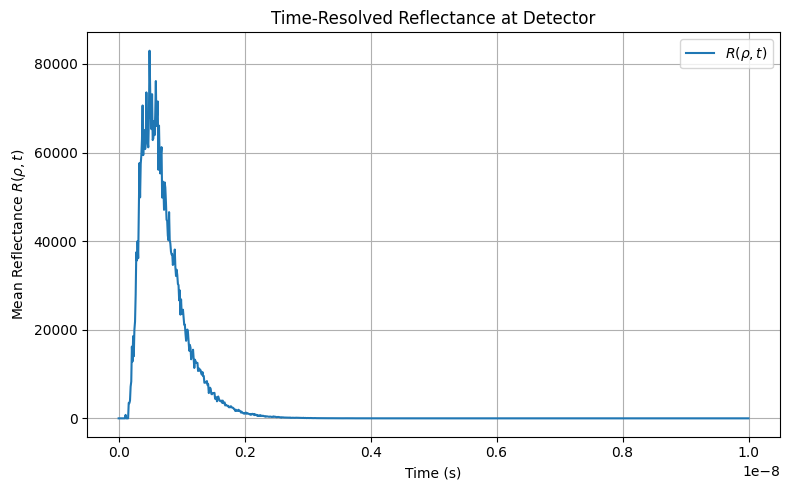

In [9]:
# Plot
times = np.linspace(0, len(data)*time_unit, len(data))
plt.figure(figsize=(8, 5))
plt.plot(times, data, label=r"$R(\rho, t)$")
plt.xlabel("Time (s)")
plt.ylabel("Mean Reflectance $R(\\rho, t)$")
plt.title("Time-Resolved Reflectance at Detector")
plt.grid(True)
#plt.xlim(0, 0.1e-8)
plt.legend()
plt.tight_layout()
plt.show()

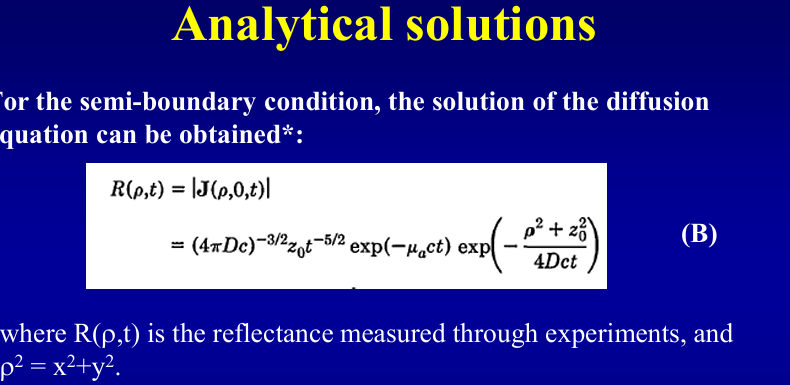

In [10]:
mean_dref_per_time_ln = [np.log(x) for x in data]
print(len(mean_dref_per_time_ln))

1000


<ipython-input-10-340a4d239aa6>:1: RuntimeWarning: divide by zero encountered in log
  mean_dref_per_time_ln = [np.log(x) for x in data]


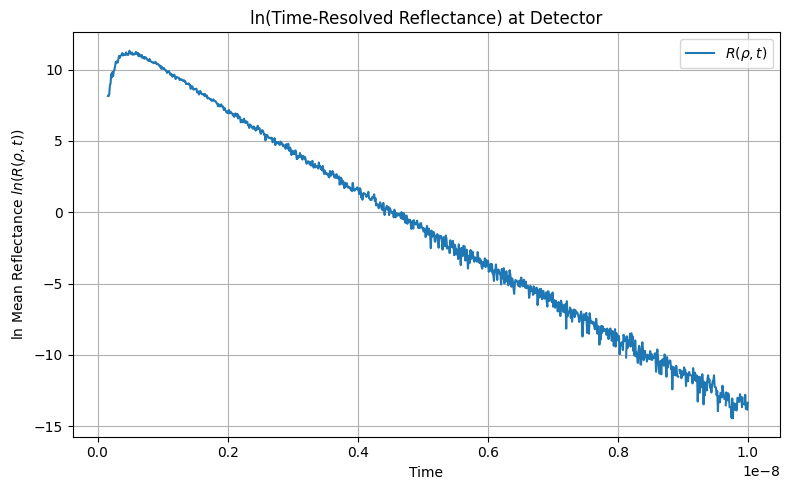

In [11]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(times, mean_dref_per_time_ln, label=r"$R(\rho, t)$")
plt.xlabel("Time")
plt.ylabel("ln Mean Reflectance $ln(R(\\rho, t))$")
plt.title("ln(Time-Resolved Reflectance) at Detector")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
def compute_slope(x1, y1, x2, y2):
  if x2 != x1:
      return (y2 - y1) / (x2 - x1)
  else:
      return None

In [13]:
ua = -(compute_slope(time_unit* 100, mean_dref_per_time_ln[100], time_unit*350, mean_dref_per_time_ln[350]))/c
print('ua=', ua,'/mm-1')
print('ua=',ua*10,'/cm-1')

ua= 0.1329864 /mm-1
ua= 1.329864 /cm-1


### Package testing

In [9]:
from FD_msNIRS import mcx_fft as mf
from FD_msNIRS import extract_freq as ef
import numpy as np
import matplotlib.pyplot as plt

In [30]:
ua = 0.01 # mm-1
us = 15 # mm-1
ua_cm = ua*10
us_cm = us*10
tstep = 1e-08/1000
nphoton = 1e8

In [7]:
fft_result, freqs = mf(ua, us, g=0.85, n=1.370, distance = 15, tend =1e-08, devf = 1000, nphoton = 1e8)

nphoton: 1e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1


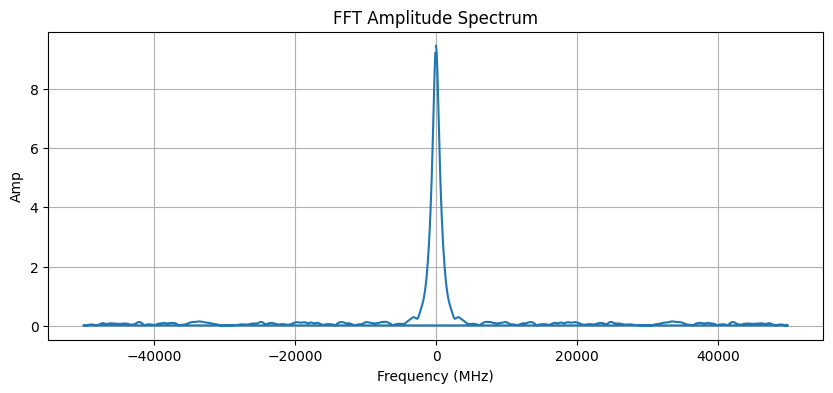

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(freqs / 1e6, np.abs(fft_result)/500)
plt.title("FFT Amplitude Spectrum")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Amp")
plt.grid(True)
plt.show()

In [23]:
uac, udc, phase = ef(500e6, freqs, fft_result)

In [24]:
print('phase(radius) = ', phase)
print('amp = ', uac)
print('dc= ', udc)

phase(radius) =  -1.9903845
amp =  5.869177
dc=  4.726152


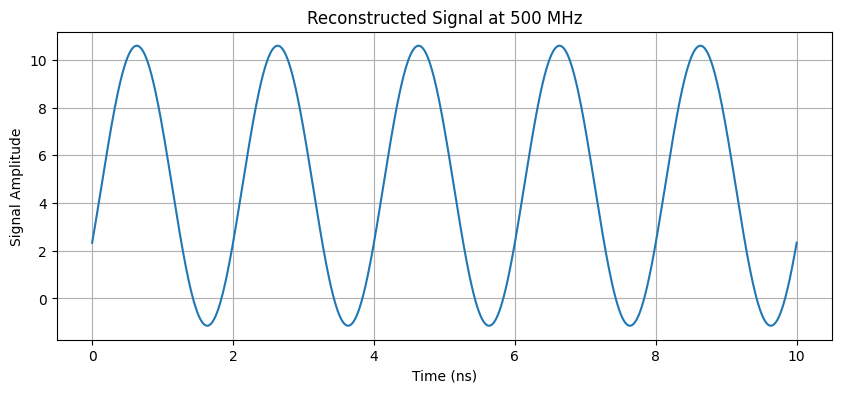

In [26]:
# Time vector for 5 cycles
T = 1 / 500e6
t = np.linspace(0, 5 * T, 1000)
signal = udc + uac * np.cos(2 * np.pi * 500e6 * t + phase)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t * 1e9, signal)  # time in ns
plt.title("Reconstructed Signal at 500 MHz")
plt.xlabel("Time (ns)")
plt.ylabel("Signal Amplitude")
plt.grid(True)
plt.show()

### Frequencies vs Phase vs Amp

In [27]:
Uacs = []
Udcs = []
phases = []
for i in freqs:
  uac, udc, ph = ef(i, freqs, fft_result)
  Uacs.append(uac)
  Udcs.append(udc)
  phases.append(ph)

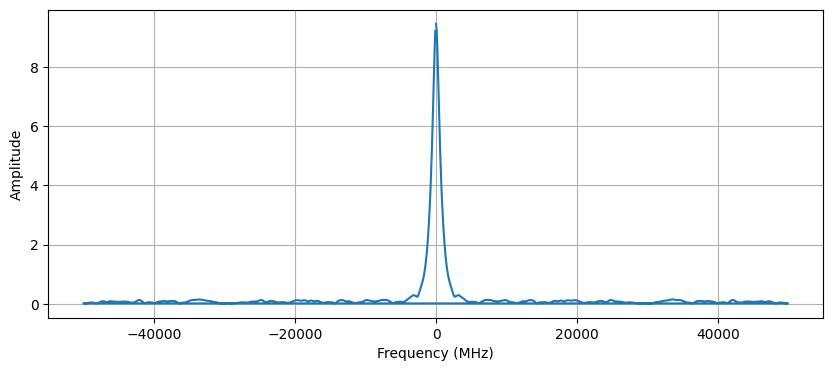

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(freqs / 1e6, Uacs)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

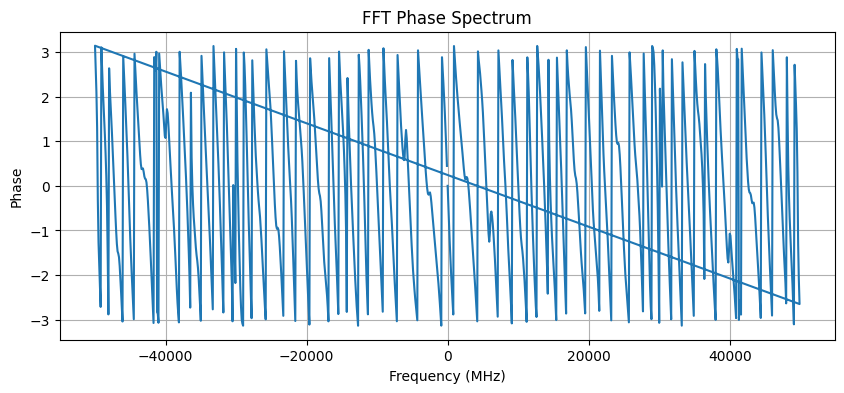

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(freqs / 1e6, phases)
plt.title("FFT Phase Spectrum")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Phase")
plt.grid(True)
plt.show()